In [ ]:
!pip install --upgrade numpy
!pip install --upgrade nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 45.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.7 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


In [ ]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import zipfile
from tensorflow import keras
import nibabel as nib
from scipy import ndimage

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print('Device:', tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.AUTOTUNE

Number of replicas: 1


# **a) Xray pneumonia classification with convnet**

In [ ]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ['NORMAL', 'PNEUMONIA']

In [ ]:
train_images = tf.data.TFRecordDataset('gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec')
train_paths = tf.data.TFRecordDataset('gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec')

test_images = tf.data.TFRecordDataset('gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec')
test_paths = tf.data.TFRecordDataset('gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec')

ds = tf.data.Dataset.zip((train_images, train_paths))
test_ds = tf.data.Dataset.zip((test_images, test_paths))

In [ ]:
train_images, train_paths

(<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>,
 <TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>)

In [ ]:
for filename in train_paths:
  print(filename)
  break

tf.Tensor(b'./NORMAL/IM-0115-0001.jpeg', shape=(), dtype=string)


In [ ]:
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if 'NORMAL' in filename.numpy().decode('utf-8')
    ]
)
print('Normal images count in training set: ' + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if 'PNEUMONIA' in filename.numpy().decode('utf-8')
    ]
)
print('Pneumonia images count in training set: ' + str(COUNT_PNEUMONIA))

Normal images count in training set: 1349
Pneumonia images count in training set: 3883


In [ ]:
def get_label(file_path):
    parts = tf.strings.split(file_path, '/')
    return parts[-2] == 'PNEUMONIA'

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, IMAGE_SIZE)

def process_path(image, path):
    label = get_label(path)
    img = decode_img(image)
    return img, label

ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
ds = ds.shuffle(10000)
train_ds = ds.take(6000)
val_ds = ds.skip(6000)

In [ ]:
for image, label in train_ds.take(1):
    print('Image shape: ', image.numpy().shape)
    print('Label: ', label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [ ]:
def prepare_for_training(ds, cache=True):
    if cache:
      if isinstance(cache, str):
          ds = ds.cache(cache)
      else:
          ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

In [ ]:
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print('Initial bias: {:.5f}'.format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Initial bias: 1.05724
Weight for class 0: 1.94
Weight for class 1: 0.67


In [ ]:
def conv_block(filters, inputs):
  x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(inputs)
  x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  outputs = tf.keras.layers.MaxPool2D()(x)
  return outputs

def dense_block(units, dropout_rate, inputs):
  x = tf.keras.layers.Dense(units, activation='relu')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  outputs = tf.keras.layers.Dropout(dropout_rate)(x)
  return outputs

In [ ]:
def build_model():
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = conv_block(32, x)
    x = conv_block(64, x)
    x = conv_block(128, x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = conv_block(256, x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Flatten()(x)
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('xray_model.h5', save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

In [ ]:
model = build_model()

METRICS = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=METRICS,
)

history = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/5
    327/Unknown - 577s 2s/step - loss: 0.3667 - binary_accuracy: 0.8345 - precision: 0.9556 - recall: 0.8148

327/327 [==============================] - 660s 2s/step - loss: 0.3667 - binary_accuracy: 0.8345 - precision: 0.9556 - recall: 0.8148
Epoch 2/5
327/327 [==============================] - ETA: 0s - loss: 0.2169 - binary_accuracy: 0.9197 - precision: 0.9745 - recall: 0.9158

327/327 [==============================] - 434s 1s/step - loss: 0.2169 - binary_accuracy: 0.9197 - precision: 0.9745 - recall: 0.9158
Epoch 3/5
327/327 [==============================] - ETA: 0s - loss: 0.2074 - binary_accuracy: 0.9297 - precision: 0.9754 - recall: 0.9287

327/327 [==============================] - 433s 1s/step - loss: 0.2074 - binary_accuracy: 0.9297 - precision: 0.9754 - recall: 0.9287
Epoch 4/5
327/327 [==============================] - ETA: 0s - loss: 0.1834 - binary_accuracy: 0.9337 - precision: 0.9771 - recall: 0.9325

327/327 [==============================] - 434s 1s/step - loss: 0.1834 - binary_accuracy: 0.9337 - precision: 0.9771 - recall: 0.9325
Epoch 5/5
327/327 [==============================] - ETA: 0s - loss: 0.1599 - binary_accuracy: 0.9400 - precision: 0.9788 - recall: 0.9395

327/327 [==============================] - 432s 1s/step - loss: 0.1599 - binary_accuracy: 0.9400 - precision: 0.9788 - recall: 0.9395


In [ ]:
model.evaluate(test_ds, return_dict=True)

39/39 [==============================] - 17s 402ms/step - loss: 0.5371 - binary_accuracy: 0.7885 - precision: 0.7490 - recall: 0.9949


{'loss': 0.537092387676239,
 'binary_accuracy': 0.7884615659713745,
 'precision': 0.7490347623825073,
 'recall': 0.9948717951774597}

<ipython-input-20-ac5bdff6308d>:3: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  plt.title(CLASS_NAMES[label[0].numpy()])


1/1 [==============================] - 2s 2s/step
This image is 49.61 percent NORMAL
This image is 50.39 percent PNEUMONIA


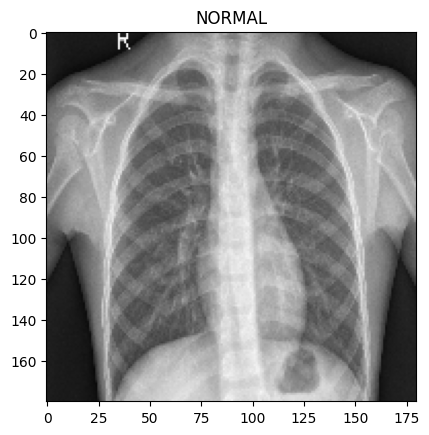

In [ ]:
for image, label in test_ds.take(1):
    plt.imshow(image[0] / 255.0)
    plt.title(CLASS_NAMES[label[0].numpy()])

prediction = model.predict(test_ds.take(1))[0]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
    print('This image is %.2f percent %s' % ((100 * score), name))

# **b) 3d image classication of ctscan **

In [ ]:
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
keras.utils.get_file(filename, url)

os.makedirs("MosMedData")

with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

1045162547/1045162547 [==============================] - 15s 0us/step


In [ ]:
def read_nifti_file(filepath):
    """Read and load volume"""
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    img = ndimage.rotate(img, 90, reshape=False)
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img

def process_scan(path):
    """Read and resize volume"""
    volume = read_nifti_file(path)
    volume = normalize(volume)
    volume = resize_volume(volume)
    return volume

In [ ]:
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


In [ ]:
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


In [ ]:
import random

from scipy import ndimage

@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        angles = [-20, -10, -5, 5, 10, 20]
        angle = random.choice(angles)
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [ ]:
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [ ]:
def get_model(width, height, depth):
    inputs = keras.Input((width, height, depth, 1))
    
    x = keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPool3D(pool_size=2)(x)
    
    # Add more layers as needed
    
    model = keras.Model(inputs=inputs, outputs=x)
    return model


    x = keras.layers.MaxPool3D(pool_size=2)(x)
    x = keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = keras.layers.MaxPool3D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = keras.layers.MaxPool3D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = keras.layers.MaxPool3D(pool_size=2)(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.GlobalAveragePooling3D()(x)
    x = keras.layers.Dense(units=512, activation="relu")(x)
    x = keras.layers.Dropout(0.3)(x)

    outputs = keras.layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 batch_normalization_7 (Batc  (None, 126, 126, 62, 64)  256      
 hNormalization)                                                 
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 63, 63, 31, 64)   0         
 3D)                                                             
                                                                 
Total params: 2,048
Trainable params: 1,920
Non-trainable params: 128
_______________________________________________________

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

epochs = 40
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

In [ ]:

model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )